# Pulmonary Fibrosis - Predicting Progression from Baseline CT Scans and Patient Characteristics

## Combined Model V10

In [1]:
import os
import cv2
import pydicom
import pylibjpeg
import gdcm
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, MaxPooling2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
) 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model
from tensorflow.keras.utils import Sequence
import tensorflow.keras.applications as tfa

from tensorflow.keras.optimizers import Nadam
import seaborn as sns
from PIL import Image
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import EarlyStopping

from numpy import loadtxt
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import concatenate

from scipy import stats
import seaborn as sns

import itertools

def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [2]:
#Uncomment this code for training on a multi-GPU VM
#mirrored_strategy = tf.distribute.MirroredStrategy()

# Preparing the data that will fit the models #
We have created a separated notebook for EDA of tabular data and images. Here we show the functions and classes that allow us to extract the data that will go into the models.

In [3]:
#read the tabular data from train.csv
df_import = pd.read_csv('./train.csv')


### Calculate output value (Least Squares Slope of FVC) for all patients
Include intercept cause we'll need it for plotting later

In [4]:
def create_output(df):

    #Create containers to store the data 
    target = pd.DataFrame(columns=['Patient', 'Slope']) # dictionary with target output 

    #Calculate slope for each patient in the train set
    for p in df.Patient.unique():
        #subsample the training set
        sub = df[df.Patient == p]
        #get the FVC for the p-patient
        fvc = sub.FVC.values
        #get the Weeks for the p-patient
        weeks = sub.Weeks.values

        #calculate the slope using linar regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(weeks, fvc)

        #fill out dictionaries with corresponding data
        target = target.append({'Patient' : p, 'Slope' : slope}, ignore_index = True)
        
    return target

In [5]:
target = create_output(df_import)

### Scale the output variable

In [6]:
slope=target.Slope.values.copy()
slope = slope.reshape(-1, 1)
slope_scaler = MinMaxScaler()
scaled_slope = slope_scaler.fit_transform(slope)

### Process Input Dataframe to Generate Baseline Tabular Data for Each Patient

In [7]:
tabular = pd.DataFrame(columns =['Patient', 'FVC', 'Percent', 'Age', 'Sex', 'SS1', 'SS2'])

for p in df_import.Patient.unique():
    
    sub=df_import[df_import.Patient ==p]
    
    f = sub.FVC.values[0]
    pct = sub.Percent.values[0]
    a = sub.Age.values[0]
    s = sub.Sex.values[0]
    ss = sub.SmokingStatus.values[0]
    
    #encode the categorical variables
    
    if s == 'male':
        s_enc = 0
    else:
        s_enc = 1
    
    if ss == 'Never smoked':
        #encode as 0,0
        ss_1 = 0
        ss_2 = 0
    elif ss == 'Ex-smoker':
        #encode as 1, 1
        ss_1 = 1
        ss_2 = 1
    elif ss == 'Currently smokes':
        #encode as 0,1
        ss_1 = 0
        ss_2 = 1

    
    tabular = tabular.append({'Patient': p, 'FVC': f, 'Percent': pct, 'Age': a, 'Sex': s_enc, 'SS1': ss_1, 'SS2': ss_2}, ignore_index=True)

### Scale the tabular values

In [8]:

fvc = tabular.FVC.values.reshape(-1, 1)
pct = tabular.Percent.values.reshape(-1, 1)
age = tabular.Age.values.reshape(-1, 1)

fvc_scaler = MinMaxScaler()
pct_scaler = MinMaxScaler()
age_scaler = MinMaxScaler()

fvc_scaled = fvc_scaler.fit_transform(fvc)
pct_scaled = pct_scaler.fit_transform(pct)
age_scaled = age_scaler.fit_transform(age)

sex = tabular.Sex.values.reshape(-1, 1)
ss1 = tabular.SS1.values.reshape(-1, 1)
ss2 = tabular.SS2.values.reshape(-1, 1)

### Recombine processed data back into Pandas before holdback

In [9]:

df_processed = pd.DataFrame()
df_processed['Patient'] = df_import.Patient.unique()
df_processed['Target'] = scaled_slope
df_processed['FVC']= fvc_scaled
df_processed['PCT'] = pct_scaled
df_processed['Age'] = age_scaled
df_processed['Sex'] = sex
df_processed['SS1'] = ss1
df_processed['SS2'] = ss2


### Make dictionaries for train test data selection

In [10]:
target={}
TAB = {}
for p in df_processed.Patient.unique():
    sub = df_processed[df_processed.Patient == p]
    target[p] = sub.Target.values[0]
    
    vector = [sub.FVC.values[0]]
    vector.append(sub.PCT.values[0])
    vector.append(sub.Age.values[0])
    vector.append(sub.Sex.values[0])
    vector.append(sub.SS1.values[0])
    vector.append(sub.SS2.values[0])
    vector = np.array(vector)
    
    TAB[p] = vector

### Select some patients to hold back to assess model performance

In [11]:
#get the full list of patient IDs
patient_ID = df_processed.Patient.unique()

In [12]:
#split the remaining patient IDs into train and test 
split = train_test_split(patient_ID, test_size=0.25, random_state=42)

(train_ID, test_ID) = split

### Image Processing

Process dicom images into format that CNN can use

In [13]:
#Function to process images
def get_img(path):
    """This function receives a path as an input,
    and outputs a resized CT scan image that was
    also transformed into Hounsfield units. The information 
    needed to transform the voxels is included in the
    metadata contained in each CT scan"""

    pd = pydicom.dcmread(path)
    r = cv2.resize((pd.pixel_array - pd.RescaleIntercept) / (pd.RescaleSlope * 1000), (512, 512))

    return r

Sample images for each patient and create tables of images combined with target output and tabular data (can be used to sample n_images for each patient or train on all available images)

In [14]:
def process_images(patient_IDs, target, TAB, flag='sample', n_images=40):
    
    Target = []
    tab = []
    image = []
    
    df_data={}
    for p in patient_IDs:
        df_data[p] = os.listdir(f'./train/{p}/')
        
        if flag=='all':
    
            for item in df_data[p]:
                img = get_img(f"./train/{p}/{item}") #apply function to process the images
                image.append(img) #append the image to the list
                Target.append(target[p]) #append target output for the patient
                tab.append(TAB[p]) #append tabular data for the patient
        
        if flag=='sample':
            for n in range(0, n_images):
                i = np.random.choice(df_data[p], size = 1)[0] #select a random image from the patient directory
                img = get_img(f"./train/{p}/{i}") #apply function to process the images
                image.append(img) #append the image to the list
                Target.append(target[p]) #append target output for the patient
                tab.append(TAB[p]) #append tabular data for the patient
            
    image, Target, tab = np.array(image), np.array(Target), np.array(tab)
    image = np.expand_dims(image, axis = -1)
    
    return Target, tab, image

### Cache Train and Test Data in RAM

In [15]:
train_target, train_tab, train_image = process_images(train_ID, target, TAB, flag='sample', n_images=40)

In [16]:
test_target, test_tab, test_image = process_images(test_ID, target, TAB, flag='sample', n_images=40)

## Model Result Evaluation Functions

### Comparison Metrics Using Holdout Data

Predict FVC for each week the patient was measured in the holdout data and compare the predicted vs. actual value

In [25]:
def compare_predictions_new(model_input, data_type, df_input = df_import, patient_IDs= test_ID, target=target, TAB=TAB, slope_scaler=slope_scaler, n_images=24):
    '''
    df_input: held back data frame of patients from original sample
    model_input: name of trained model for inference
    data_type: type of data for prediction - either 'image' for CNN, 'text' for MLP, or 'combined' for combined
    '''
    # define a quantile (in this case the median)
    q = 0.5

    predictions = pd.DataFrame(columns=['Patient', 'Weeks', 'FVC_prediction'])

    calculated = pd.DataFrame(columns=['Patient', 'Weeks', 'FVC_calculated'])
    
    df_data={}
    
    for p in patient_IDs:
        #print(p)
        a = []
        
        df_data[p] = os.listdir(f'./train/{p}/')
        #print(os.listdir(f'./train/{p}/'))

        for n in range(0, n_images):
            tab= []
            img= []
            
            if data_type!='text':
                i = np.random.choice(df_data[p], size = 1)[0] #select a random image from the patient directory
                image = get_img(f"./train/{p}/{i}") #apply function to process the images
                img.append(image)
            
            #image = np.array(img)
            img = np.expand_dims(img, axis = -1)
            
            tab.append(TAB[p])
            tab = np.array(tab)
            
            #Use the saved model to predict the linear decay of the patient
            #Per the model, this is going to give us an estimated slope per patient

            if data_type=='image':
                _a = model_input.predict([img])
                a.append(_a)

            if data_type=='text':
                _a = model_input.predict([tab])
                a.append(_a)

            if data_type=='combined':
                _a = model_input.predict([tab, img])
                a.append(_a)
                

        slope_p = np.mean(a)
        
        slope_p = slope_p.reshape(-1, 1)
        
        slope_p = slope_scaler.inverse_transform(slope_p)
        
        slope_p = slope_p[0][0]

        #Get the predicted slope

        #subsample the training set
        sub = df_input[df_input.Patient == p]
        #get the FVC for the p-patient
        fvc = sub.FVC.values
        #get the Weeks for the p-patient
        weeks = sub.Weeks.values

        #calculate the slope using linar regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(weeks, fvc)

        #calculated the predicted y intercept - using baseline measurement

        constant_p=fvc[0]-(slope_p*weeks[0])

        #generate FVC predicted and calculated values for observed weeks
        for w in weeks:

            #1 - generate predicted FVC values from the model estimated slope

            #Matrix multiplication and addition to calculate fvc
            #Decay * Week + Baseline FVC
            fvc_predicted = float(slope_p*w + constant_p)

            #Save predictions - append the patient, week and fvc prediction to the empty predictions dataframe
            predictions = predictions.append({'Patient' : p, 'Weeks' : w, 'FVC_prediction' : fvc_predicted}, ignore_index = True) 

            #2 - calculate predicted FVC values from the least squares estimate per patient

            fvc_calculated = float(slope*w + intercept)

            calculated = calculated.append({'Patient' : p, 'Weeks' : w, 'FVC_calculated' : fvc_calculated}, ignore_index = True) 


    #prepare the comparison for the output

    #subset the copy of the input dataframe for the relevant columns
    output = df_input[['Patient', 'Weeks', 'FVC']]

    #merge with the predictions dataframe for the comparison
    output = pd.merge(output, predictions, on=['Patient', 'Weeks'])

    #merge with the calculated slope dataframe for the comparison
    output = pd.merge(output, calculated, on=['Patient', 'Weeks'])
    output = output.drop_duplicates()

    #calculate the absolute error between actual value and prediction

    output['abs_error_pred'] = abs(output.FVC - output.FVC_prediction)

    #calculate the absolute error between actual value and least squares estimate

    output['abs_error_calc'] = abs(output.FVC - output.FVC_calculated)
    
    output['calc_vs_pred'] = abs(output.FVC_calculated - output.FVC_prediction)

    return output

### Predict the slope for patient based on mean of that patient's scans (n_images) - more useful for inference on a given patient

In [26]:
def compare_slope_per_pt(model_input, data_type, df_input = df_import, patient_IDs=test_ID, target=target, TAB=TAB, slope_scaler=slope_scaler, n_images=24):
    '''
    df_input: held back data frame of patients from original sample
    model_input: name of trained model for inference
    data_type: type of data for prediction - either 'image' for CNN, 'text' for MLP, or 'combined' for combined
    '''
    q = 0.5

    slopes = pd.DataFrame(columns=['Patient', 'Calculated_Slope', 'Lower_CI', 'Upper_CI', 'Predicted_Slope', 'Within_Range'])
    
    df_data={}
    
    for p in patient_IDs:
        #print(p)
        a = []
        
        df_data[p] = os.listdir(f'./train/{p}/')
        #print(os.listdir(f'./train/{p}/'))

        for n in range(0, n_images):
            tab= []
            img= []
            
            if data_type!='text':
                i = np.random.choice(df_data[p], size = 1)[0] #select a random image from the patient directory
                image = get_img(f"./train/{p}/{i}") #apply function to process the images
                img.append(image)
            
            #image = np.array(img)
            img = np.expand_dims(img, axis = -1)
            
            tab.append(TAB[p])
            tab = np.array(tab)

            #Use the saved model to predict the linear decay of the patient
            #Per the model, this is going to give us an estimated slope per patient

            if data_type=='image':
                _a = model_input.predict([img])
                a.append(_a)

            if data_type=='text':
                _a = model_input.predict([tab])
                a.append(_a)

            if data_type=='combined':
                _a = model_input.predict([tab, img])
                a.append(_a)
                

        slope_p = np.mean(a)
        
        slope_p = slope_p.reshape(-1, 1)
        
        slope_p = slope_scaler.inverse_transform(slope_p)
        
        slope_p = slope_p[0][0]

        #subsample the training set
        sub = df_input[df_input.Patient == p]
        #get the FVC for the p-patient
        fvc = sub.FVC.values
        #get the Weeks for the p-patient
        weeks = sub.Weeks.values

        #calculate the slope using linar regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(weeks, fvc)

        slope_calc=slope
        
        CI = 2.58*std_err
        
        ci_1 = slope_calc + CI
        
        ci_2 = slope_calc - CI
        
        upper_CI = max(ci_1, ci_2)
        
        lower_CI = min(ci_1, ci_2)
        
        if lower_CI < slope_p < upper_CI:
            compare = 'Yes'
        else:
            compare = 'No'
        
        slopes = slopes.append({'Patient' : p, 'Calculated_Slope' : slope_calc, 'Lower_CI' : lower_CI, 'Upper_CI': upper_CI, 
                                          'Predicted_Slope': slope_p, 'Within_Range': compare}, ignore_index = True) 
    
    return slopes

### Predict slope for each individual scan - more useful for troubleshooting/model tuning

In [27]:
def compare_slope_per_img(model_input, data_type, df_input = df_import, patient_IDs=test_ID, target=target, TAB=TAB, slope_scaler=slope_scaler, n_images=24):
    '''
    df_input: held back data frame of patients from original sample
    model_input: name of trained model for inference
    data_type: type of data for prediction - either 'image' for CNN, 'text' for MLP, or 'combined' for combined
    '''
    q = 0.5

    slopes = pd.DataFrame(columns=['Patient', 'Calculated_Slope', 'Lower_CI', 'Upper_CI', 'Predicted_Slope', 'Within_Range'])
    
    df_data={}
    
    for p in patient_IDs:
        #print(p)

        
        df_data[p] = os.listdir(f'./train/{p}/')
        #print(os.listdir(f'./train/{p}/'))
        
        #subsample the training set
        sub = df_input[df_input.Patient == p]
        #get the FVC for the p-patient
        fvc = sub.FVC.values
        #get the Weeks for the p-patient
        weeks = sub.Weeks.values

        #calculate the slope using linar regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(weeks, fvc)

        slope_calc=slope
        
        CI = 2.58*std_err
        
        ci_1 = slope_calc + CI
        
        ci_2 = slope_calc - CI
        
        upper_CI = max(ci_1, ci_2)
        lower_CI = min(ci_1, ci_2)

        for n in range(0, n_images):
            tab= []
            img= []
            
            if data_type!='text':
                i = np.random.choice(df_data[p], size = 1)[0] #select a random image from the patient directory
                image = get_img(f"./train/{p}/{i}") #apply function to process the images
                img.append(image)
            
            img = np.expand_dims(img, axis = -1)
            
            tab.append(TAB[p])
            tab = np.array(tab)

            #Use the saved model to predict the linear decay of the patient
            #Per the model, this is going to give us an estimated slope per patient

            if data_type=='image':
                _a = model_input.predict([img])

            if data_type=='text':
                _a = model_input.predict([tab])

            if data_type=='combined':
                _a = model_input.predict([tab, img])
                
            slope_p = _a
                
            slope_p = slope_p.reshape(-1, 1)
            #print(slope_p)
            slope_p = slope_scaler.inverse_transform(slope_p)
            slope_p = slope_p[0][0]
            #print(slope_p)


            if lower_CI < slope_p < upper_CI:
                compare = 'Yes'
            else:
                compare = 'No'

            slopes = slopes.append({'Patient' : p, 'Calculated_Slope' : slope_calc, 'Lower_CI' : lower_CI, 'Upper_CI': upper_CI, 
                                              'Predicted_Slope': slope_p, 'Within_Range': compare}, ignore_index = True) 

    return slopes

Return the mean values of the absolute error

In [28]:
def prediction_scores(sub, slopes):

    ave_abs_error_pred = sub.abs_error_pred.mean()
    
    ave_abs_error_calc = sub.abs_error_calc.mean()
    
    calc_vs_pred_mean = sub.calc_vs_pred.mean()
    
    total_in_CI = slopes.Within_Range[slopes.Within_Range=='Yes'].count()
    
    pct_in_CI = total_in_CI/len(slopes.Patient.unique())*100
    
    print('Least Squares Estimate Error')
    print('Mean Absolute Error, Least Squares Estimated FVC vs. Actual: ', round(ave_abs_error_calc, 2))

    print('')
    print('Predicted vs Actual FVC Values')
    print('MAE: ', round(ave_abs_error_pred, 2))
    
    print('')
    print('Model Prediction vs Least Squares Line')
    print('MAE ', round(calc_vs_pred_mean, 2))
    
    print('')
    print('Number of predicted in Slopes Within 95% CI of Least Squares Estimate')
    print(total_in_CI, 'correct', round(pct_in_CI, 1), '%')


Calculate the total number of predicted slopes within the 95% CI

In [29]:
def slope_scores(slopes):
    
    total_in_CI = slopes.Within_Range[slopes.Within_Range=='Yes'].count()
    
    pct_in_CI = total_in_CI/slopes.shape[0]*100

    
    print('')
    print('Number of predicted in Slopes Within 95% CI of Least Squares Estimate')
    print(total_in_CI, 'correct', round(pct_in_CI, 1), '%')

### Graphical Output Functions

Visualize training loss

In [30]:
def model_graph(model, start=0):
    mlp_mse = model.history['mse'][start:]
    mlp_val_mse = model.history['val_mse'][start:]
    mlp_loss = model.history['loss'][start:]
    mlp_val_loss = model.history['val_loss'][start:]

    epochs = range(1, len(mlp_mse) + 1)

    plt.plot(epochs, mlp_mse, 'bo', label='Training mse')
    plt.plot(epochs, mlp_val_mse, 'b', label='Validation mse')
    plt.title('Training and validation Mean Squared Error')
    plt.legend()

    plt.figure()

    plt.plot(epochs, mlp_loss, 'bo', label='Training loss')
    plt.plot(epochs, mlp_val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss (Mean Absolute Error)')
    plt.legend()

    plt.show()

Comparison between actual and predicted FVC

In [31]:
 def fvc_plot(scores):
    patient = scores.Patient.unique()
    rows = int(len(patient)/4)
    plt.figure(figsize = (20,rows*5))

    counter = 1
    for p in patient:
        single_patient = scores[scores['Patient'] == p]
        weeks = single_patient.Weeks
        weeks = weeks.astype('float')
        fvc = single_patient.FVC
        fvc = fvc.astype('float')

        ax = plt.subplot(rows, 4, counter)
        sns.regplot(weeks, fvc, ci=95)

        prediction = single_patient.FVC_prediction
        plt.plot(weeks, prediction, label = "Predicted")
        
        plt.xlabel("Weeks", fontsize = 10)
        plt.ylabel("FVC",  fontsize = 10)
        plt.title(p)
        counter+=1

# Model Training

## Regression with CT Scans via 2D Convolutional Neural Net

We will use a convolutional neural network. Although we are using images, we are trying to predict a continous variable. Thus, we want the CNN to solve a regression problem.

In [32]:
#Our CNN as a function

def create_cnn(regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    
    inputShape=(512, 512, 1)
    
    inputs = Input(shape=inputShape)
    
    #corresponds to our first conv2d
    x = inputs 
    x = Conv2D(32, (3, 3))(x)
    x = Activation('relu')(x)
    
    #first max pool
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    #corresponds to our second conv2d
    x = Conv2D(64, (3, 3))(x)
    x = Activation('relu')(x)
    
    #second max pool
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    #corresponds to our third 2d
    x = Conv2D(128, (3, 3))(x)
    x = Activation('relu')(x)
    
    #corresponds to our fourth 2d
    x = Conv2D(128, (3, 3))(x)
    x = Activation('relu')(x)
    
    #third max pool
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    
    x = Dense(512)(x)
    x = Activation('relu')(x)
    
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model


### Running the fully tuned model with 60 images results in the model predicting the same slope for every image - can't tell if the bug is in the image selection or if the model is overfitting

In [25]:
# CNN Training - Tuned Model, 60 patients

CNN = create_cnn(regress=True)
callback = EarlyStopping(monitor='val_loss', patience=3)
opt = Adam(lr=0.01, decay =0.1)
CNN.compile(loss='mae',
              optimizer=opt,
              metrics=['mse'])

CNN.summary()

CNN_history = []

CNN_fit = CNN.fit(x=train_image, y=train_target, validation_data = (test_image, test_target), epochs=40, batch_size=24, callbacks=[callback])

CNN_history.append(CNN_fit.history)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 510, 510, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 510, 510, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 253, 253, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 64)     

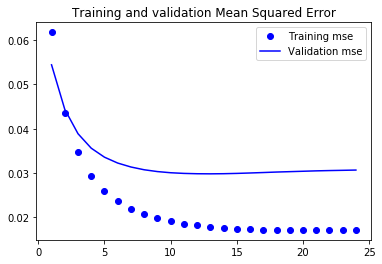

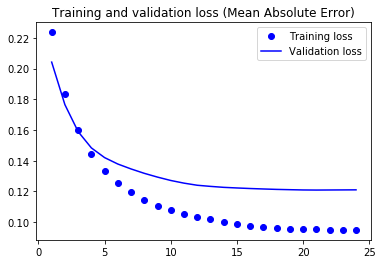

In [26]:
model_graph(CNN_fit, start=1)

In [28]:
CNN_slope_per_pt = compare_slope_per_pt(CNN, 'image', patient_IDs=test_ID)

In [29]:
slope_scores(CNN_slope_per_pt)


Number of predicted in Slopes Within 95% CI of Least Squares Estimate
23 correct 52.3 %


In [30]:
CNN_slope_per_pt

,Patient,Calculated_Slope,Lower_CI,Upper_CI,Predicted_Slope,Within_Range
0,ID00048637202185016727717,-1.190408,-2.901435,0.520618,-4.076679,No
1,ID00110637202210673668310,-28.182575,-43.359629,-13.005520,-4.076679,No
2,ID00339637202287377736231,-9.381848,-12.127840,-6.635855,-4.076679,No
3,ID00076637202199015035026,11.225948,5.072330,17.379566,-4.076679,No
4,ID00140637202231728595149,-1.510683,-6.126687,3.105322,-4.076679,Yes
5,ID00038637202182690843176,-0.800797,-4.409793,2.808199,-4.076679,Yes
6,ID00288637202279148973731,9.052208,-0.731771,18.836188,-4.076679,No
7,ID00421637202311550012437,-1.554030,-3.955740,0.847681,-4.076679,No
8,ID00251637202267455595113,-5.585897,-9.279468,-1.892325,-4.076679,Yes
9,ID00340637202287399835821,-3.814048,-7.682854,0.054758,-4.076679,Yes


### Running the less tuned model on 40 images gives unique slope predictions for each patient (as it should)

In [33]:
# running our CNN function - 40 images

CNN = create_cnn(regress=True)

opt = Adam(lr=0.00001, decay =0.0005)
CNN.compile(loss='mae',
              optimizer=opt,
              metrics=['mse'])

CNN.summary()

CNN_history = []

CNN_fit = CNN.fit(x=train_image, y=train_target, validation_data = (test_image, test_target), epochs=10, batch_size=24)

CNN_history.append(CNN_fit.history)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 510, 510, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 510, 510, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 253, 253, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 64)     

In [34]:
CNN_slope_per_pt = compare_slope_per_pt(CNN, 'image', patient_IDs=test_ID)

In [35]:
CNN_slope_per_pt

,Patient,Calculated_Slope,Lower_CI,Upper_CI,Predicted_Slope,Within_Range
0,ID00048637202185016727717,-1.190408,-2.901435,0.520618,-2.523407,Yes
1,ID00110637202210673668310,-28.182575,-43.359629,-13.005520,-6.358183,No
2,ID00339637202287377736231,-9.381848,-12.127840,-6.635855,-6.980272,Yes
3,ID00076637202199015035026,11.225948,5.072330,17.379566,-5.411367,No
4,ID00140637202231728595149,-1.510683,-6.126687,3.105322,-1.963790,Yes
5,ID00038637202182690843176,-0.800797,-4.409793,2.808199,-3.836656,Yes
6,ID00288637202279148973731,9.052208,-0.731771,18.836188,-7.865312,No
7,ID00421637202311550012437,-1.554030,-3.955740,0.847681,-3.027547,Yes
8,ID00251637202267455595113,-5.585897,-9.279468,-1.892325,-4.362968,Yes
9,ID00340637202287399835821,-3.814048,-7.682854,0.054758,-6.184893,Yes


In [36]:
slope_scores(CNN_slope_per_pt)


Number of predicted in Slopes Within 95% CI of Least Squares Estimate
29 correct 65.9 %


### Trying fully tuned model on 40 images per patient

In [39]:
# CNN Training - Tuned Model, 40 images

CNN = create_cnn(regress=True)
callback = EarlyStopping(monitor='val_loss', patience=3)
opt = Adam(lr=0.01, decay =0.1)
CNN.compile(loss='mae',
              optimizer=opt,
              metrics=['mse'])

CNN.summary()

CNN_history = []

CNN_fit = CNN.fit(x=train_image, y=train_target, validation_data = (test_image, test_target), epochs=40, batch_size=24, callbacks=[callback])

CNN_history.append(CNN_fit.history)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 510, 510, 32)      320       
_________________________________________________________________
activation_6 (Activation)    (None, 510, 510, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 253, 253, 64)      18496     
_________________________________________________________________
activation_7 (Activation)    (None, 253, 253, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 126, 126, 64)     

Epoch 150/150
198/198 [===============] - 0s 2ms/step - loss: 0.1089 - mse: 0.0200 - val_loss: 0.1443 - val_mse: 0.0391

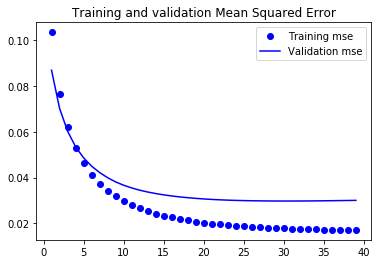

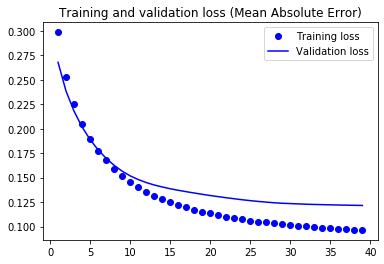

In [40]:
model_graph(CNN_fit, start=1)

In [41]:
CNN_slope_per_pt = compare_slope_per_pt(CNN, 'image', patient_IDs=test_ID)

In [42]:
CNN_slope_per_pt

,Patient,Calculated_Slope,Lower_CI,Upper_CI,Predicted_Slope,Within_Range
0,ID00048637202185016727717,-1.190408,-2.901435,0.520618,-4.593894,No
1,ID00110637202210673668310,-28.182575,-43.359629,-13.005520,-4.593894,No
2,ID00339637202287377736231,-9.381848,-12.127840,-6.635855,-4.593894,No
3,ID00076637202199015035026,11.225948,5.072330,17.379566,-4.593894,No
4,ID00140637202231728595149,-1.510683,-6.126687,3.105322,-4.593894,Yes
5,ID00038637202182690843176,-0.800797,-4.409793,2.808199,-4.593894,No
6,ID00288637202279148973731,9.052208,-0.731771,18.836188,-4.593894,No
7,ID00421637202311550012437,-1.554030,-3.955740,0.847681,-4.593894,No
8,ID00251637202267455595113,-5.585897,-9.279468,-1.892325,-4.593894,Yes
9,ID00340637202287399835821,-3.814048,-7.682854,0.054758,-4.593894,Yes


### DOES IT AGAIN!!!

## Regression with Tabular Data via Multi-Layer Perceptron

Model Building Function for Regression MLP

In [22]:
def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))

    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))

    # return our model
    return model

Run MLP

In [ ]:
mlp = create_mlp(train_tab.shape[1], regress=True)

opt = Adam(lr=0.0001, decay =0.001)

mlp.compile(loss='mae', optimizer=opt, metrics=['mse'])
mlp.summary()

mlp_history = []

print("[INFO] training model...")

mlp_fit = mlp.fit(x=train_tab, y=train_target, validation_data=(test_tab, test_target), epochs=150, batch_size=24)

mlp_history.append(mlp_fit.history)

Save model

In [ ]:
#mlp.save('fvc_mlp_nov19.h5')

Load saved model

In [ ]:
#mlp_predict = load_model('fvc_mlp_1.h5')
# summarize model.
#mlp_predict.summary()

Assess Model Results

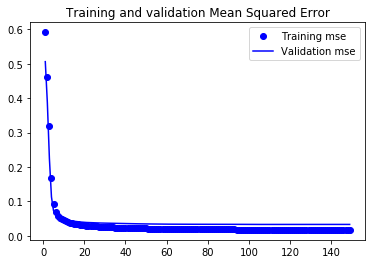

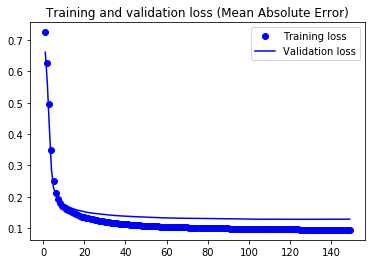

In [24]:
model_graph(mlp_fit, start=1)

In [25]:
scores_mlp = compare_predictions_new(mlp, 'text')
slope_mlp = compare_slope_new(mlp, 'text')
prediction_scores(scores_mlp, slope_mlp)

Least Squares Estimate Error
Mean Absolute Error, Least Squares Estimated FVC vs. Actual:  71.01

Predicted vs Actual FVC Values
MAE:  145.62

Model Prediction vs Least Squares Line
MAE  128.29

Number of predicted in Slopes Within 95% CI of Least Squares Estimate
24 correct 54.5 %


In [ ]:
slope_mlp

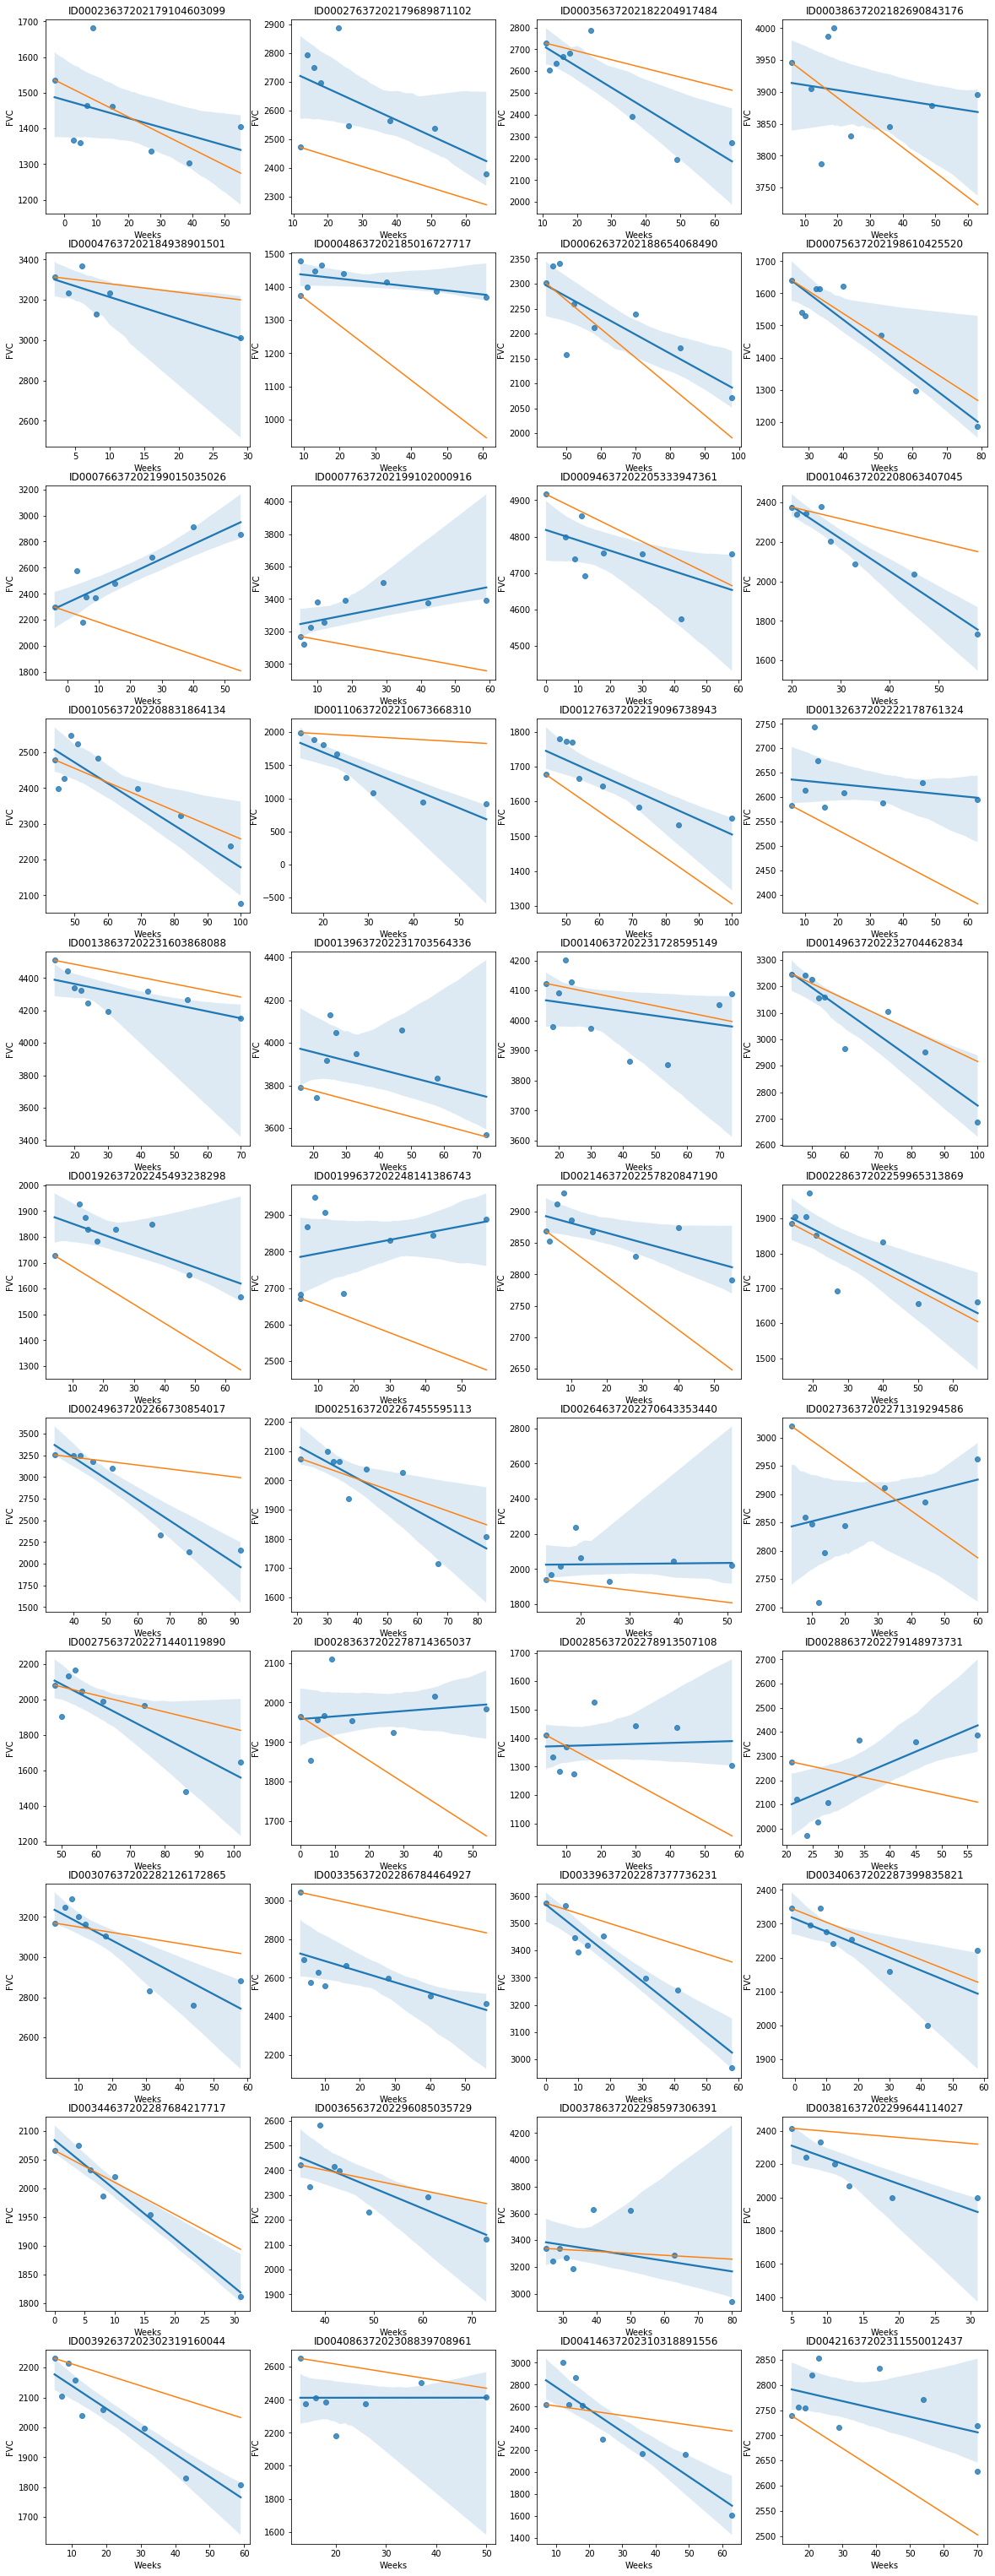

In [27]:
fvc_plot(scores_mlp)

opt = Adam(lr=0.001, decay =0.001) first layer 10, epochs 100

In [46]:
slope_mlp = compare_slope_new(mlp, 'text')

**best run - opt = Adam(lr=0.001, decay =0.01), epochs 100, batch size 16, second layer 8

## Combined Model

Run the combined model incoprorating multi-layer perceptron for tabular data and CNN for image data

In [ ]:
mlp = create_mlp(train_tabular.shape[1], regress=False)
cnn = create_cnn(regress=False)

combinedInput = concatenate([mlp.output, cnn.output])

x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

Combined = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = Adam(lr=0.0001, decay=0.001)

Combined.compile(loss='mae', optimizer=opt, metrics=['mse'])

Combined.summary()

model_history = []

Combined_fit = Combined.fit(x=[train_tabular, train_images], y=train_target,
                            validation_data=([test_tabular, test_images], test_target),
                            epochs=60, batch_size=8)

model_history.append(Combined_fit.history)

Save model

In [ ]:
Combined.save('fvc_combined_nov19.h5')

Load saved model

In [ ]:
#Combined = load_model('fvc_combined_1.h5')
# summarize model
#mlp_predict.summary()

Assess Model Results

In [ ]:
model_graph(Combined_fit, start=0)

In [ ]:
scores =  compare_predictions(holdback, Combined, 'combined')

In [ ]:
prediction_scores(scores)

In [ ]:
fvc_plot(scores)

## Possible further model steps?

* Smoothing the series - averaging by time period?
* Trimming initial observations?
* Difference between max and min?
* predict FVC at 50 weeks?
* predict time to 50% decrease?

In [ ]:
test = pd.read_csv("./test.csv")

In [ ]:
test

In [ ]:
test

In [ ]:
test.Patient.values

In [ ]:
holdback.Patient.values

In [ ]:
test_single = holdback[holdback.Patient== 'ID00023637202179104603099']

In [ ]:
test_single

In [ ]:
# def compare_predictions(df_input, model_input, data_type):

df_input = test_single
model_input = Combined
data_type = 'combined'

In [ ]:
# define a quantile (in this case the median)
q = 0.5

slope_predicted={}
slope_calculated={}
constant_calculated={}
constant_predicted={}

predictions = pd.DataFrame(columns=['Patient', 'Weeks', 'FVC_prediction'])

calculated = pd.DataFrame(columns=['Patient', 'Weeks', 'FVC_calculated'])


for p in df_input.Patient.unique():

    #Data processing stuff

    x = [] #image container
    tab = [] #tabular data container
    ldir = os.listdir(f'./train/{p}') #list of slices in the patient-folder

    #image getting stuff
    #for each image file in the patient folder
    for i in ldir:
        if int(i[:-4]) / len(ldir) < 1.1 and int(i[:-4]) / len(ldir) > -0.1:
            x.append(get_img(f'./train/{p}/{i}'))
            tab.append(get_tab(df_input.loc[df_input.Patient == p, :])) #append tab.data
    if len(x) <= 1:
        continue
    tab = np.array(tab)

    #Turn the image list into an array and add a new axis at the end
    x = np.expand_dims(x, axis = -1)

    #Use the saved model to predict the linear decay of the patient
    #Per the model, this is going to give us an estimated slope per patient

    if data_type=='image':
        _a = model_input.predict([x]) # originally model.predict([x,tab])

    if data_type=='text':
        _a = model_input.predict([tab])

    if data_type=='combined':
        _a = model_input.predict([tab, x])

    a = np.quantile(_a, q)

    #Get the predicted slope
    slope_predicted[p] = a

In [ ]:
_a

In [ ]:
a